### Imports

In [1]:
import sys
import json
import matplotlib.pyplot as plt
import numpy as np

### Local imports

In [2]:
sys.path.insert(0,'src/')
from src.metrics import BinaryClassificationResult
from src.print_util import print_rates

### Functions

In [3]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_results_non_federated(all_results):
    result = BinaryClassificationResult()
    for configuration, configuration_results in all_results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_result in enumerate(configuration_results):
            result += BinaryClassificationResult(*run_result.values())

    return result

In [4]:
# Get the results for each federation round of a single experiment, summed over the reruns and the configurations
def get_results_per_round(all_results):
    results_per_round = []
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            for federation_round, round_results in enumerate(run_results):
                if federation_round >= len(results_per_round):
                    results_per_round.append(BinaryClassificationResult())  
                results_per_round[federation_round] += BinaryClassificationResult(*round_results.values())
                
    return results_per_round

In [5]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_thresholds_federated(all_thresholds):
    thresholds_sum = []
    n = 0
    for configuration, configuration_thresholds in all_thresholds.items():
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run_thresholds in configuration_thresholds:
            n += 1
            for federation_round, round_threshold in enumerate(run_thresholds):
                if federation_round >= len(thresholds_sum):
                    thresholds_sum.append(0.)  
                thresholds_sum[federation_round] += round_threshold
    thresholds = [s / n for s in thresholds_sum]
                
    return thresholds

In [6]:
def plot_federated_tpr_tnr(results_to_plot, title=''):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_xlabel('Federation round')

    color = 'blue'
    ax1.set_title(title)
    ax1.set_ylabel('TPR', color=color)
    ax1.plot([result.tpr() for result in results_to_plot], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('TNR', color=color)
    ax2.plot([result.tnr() for result in results_to_plot], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

In [7]:
def plot_federated_acc(results_to_plot, title=''):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_xlabel('Federation round')

    color = 'green'
    ax.set_title(title)
    ax.set_ylabel('Accuracy', color=color)
    ax.plot([result.acc() for result in results_to_plot], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    plt.show()

In [8]:
def plot_global_thresholds(thresholds, title='', multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color = 'purple'
    ax.set_title(title)
    ax.set_ylabel('Threshold', color=color)
    
    if multi_epoch:
        ax.set_xlabel('Federation round')
        ax.plot(thresholds, color=color)
    else:
        ax.set_xlabel('Epoch')
        ax.set_xticks(np.arange(0, 120, step=10))
        ax.plot(np.arange(0,120, step=10), thresholds, color=color)

    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    plt.show()
    if save:
        fig.savefig('thresholds' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

In [9]:
def percentage_str(value, bf=False):
    s = '{:.2f}\\%'.format(value * 100)
    if bf:
        s = '\\textbf{' + s + '}'
    return s

In [10]:
def print_rates_latex(results):
    print('Accuracy:\t' + percentage_str(results.acc(), bf=True))
    print('TPR:\t\t' + percentage_str(results.tpr()))
    print('TNR:\t\t' + percentage_str(results.tnr()))

In [11]:
def print_rates_latex2(results):
    print('Accuracy:\t' + percentage_str(results.acc()))
    print('TPR:\t\t' + percentage_str(results.tpr()))
    print('TNR:\t\t' + percentage_str(results.tnr()))
    print('F1-Score:\t' + percentage_str(results.f1()))

### Non-federated

In [12]:
path_test = 'test_results/centralized_autoencoder/0,5 5rr/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_result = get_results_non_federated(test_local_results)
new_result = get_results_non_federated(test_new_results)
print('Local result:')
print_rates_latex(local_result)
print()

print('New result:')
print_rates_latex(new_result)

Local result:
Accuracy:	\textbf{97.36\%}
TPR:		99.98\%
TNR:		94.74\%

New result:
Accuracy:	\textbf{95.41\%}
TPR:		99.98\%
TNR:		90.85\%


### Federated

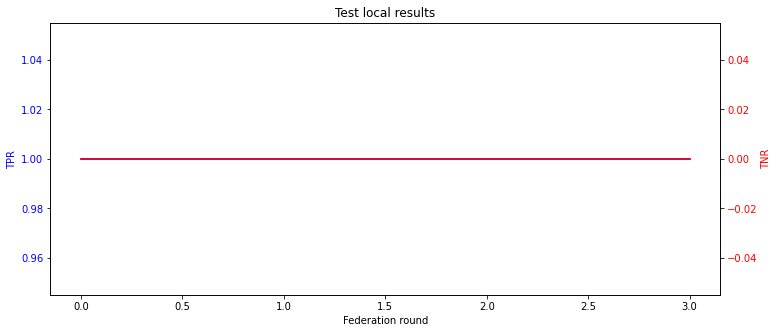

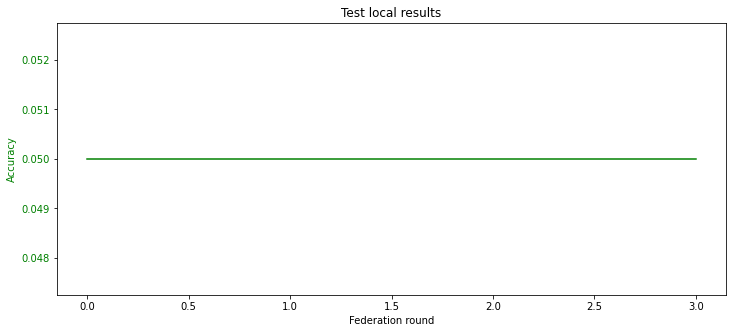

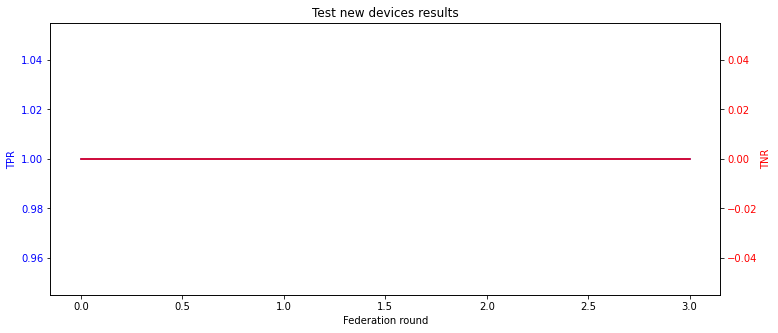

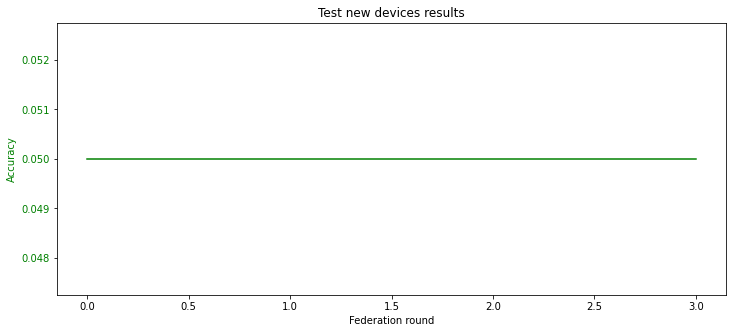

Local result at last round:
Accuracy:	5.00\%
TPR:		100.00\%
TNR:		0.00\%
F1-Score:	9.52\%

New result at last round:
Accuracy:	5.00\%
TPR:		100.00\%
TNR:		0.00\%
F1-Score:	9.52\%


In [19]:
# TODO: rename the x-axis as epoch in fedsgd and make it start at 1 in both cases

path_test = 'test_results/decentralized_classifier_fedsgd/cm vs 3factor/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_results_per_round = get_results_per_round(test_local_results)
plot_federated_tpr_tnr(local_results_per_round, title='Test local results')
plot_federated_acc(local_results_per_round, title='Test local results')

new_results_per_round = get_results_per_round(test_new_results)
plot_federated_tpr_tnr(new_results_per_round, title='Test new devices results')
plot_federated_acc(new_results_per_round, title='Test new devices results')

print('Local result at last round:')
print_rates_latex2(local_results_per_round[-1])
print()

print('New result at last round:')
print_rates_latex2(new_results_per_round[-1])

try:
    with open(path_test + 'thresholds.json') as json_file:
        all_thresholds = json.load(json_file)
    
    global_thresholds = get_thresholds_federated(all_thresholds)
    plot_global_thresholds(global_thresholds, 'Thresholds', multi_epoch=True, save=True)
except FileNotFoundError:
    pass
except e:
    print(e)

These plots are interesting but could be improved with confidence intervals.